# gwexpy.noise: 検出器および環境ノイズモデルの利用

このノートブックでは、`gwexpy.noise` サブパッケージを使用して、重力波検出器の設計感度や、地震・インフラサウンドなどの標準的な環境ノイズモデルを取得する方法を紹介します。

## 必要なライブラリのインポート

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.noise import from_pygwinc, from_obspy
from astropy import units as u

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. 重力波検出器のノイズモデル (pygwinc 連携)

`from_pygwinc` 関数を使用すると、LIGO, Virgo, KAGRA などの検出器の設計感度（ASD: Amplitude Spectral Density）を `FrequencySeries` として取得できます。
※ この機能には `pygwinc` ライブラリのインストールが必要です。

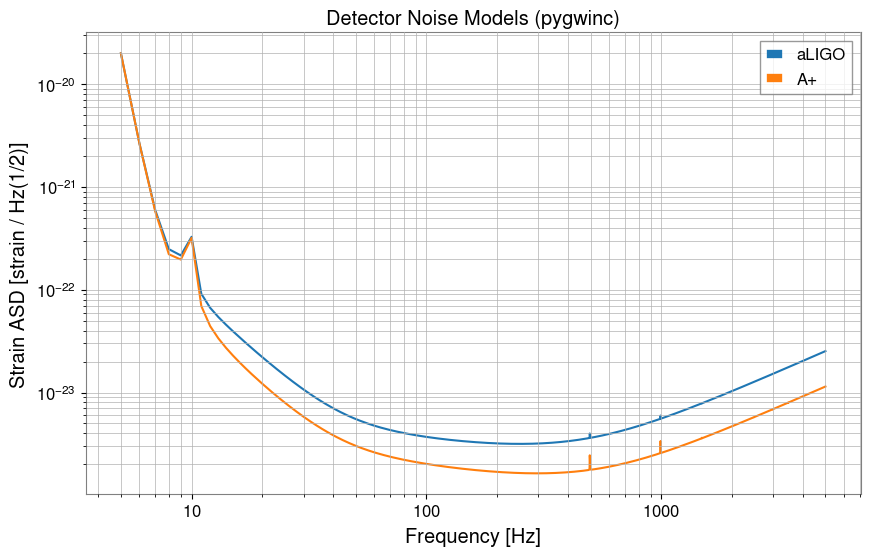

In [2]:
try:
    # aLIGO の設計感度を取得 (デフォルト: 10Hz - 4000Hz)
    asd_aligo = from_pygwinc('aLIGO', fmin=5, fmax=5000, df=1)
    
    # A+ 計画の感度を取得
    asd_aplus = from_pygwinc('A+', fmin=5, fmax=5000, df=1)
    
    # プロット
    fig = plt.figure()
    ax = fig.gca()
    ax.loglog(asd_aligo.frequencies, asd_aligo, label='aLIGO')
    ax.loglog(asd_aplus.frequencies, asd_aplus, label='A+')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(f'Strain ASD [{asd_aligo.unit}]')
    ax.grid(True, which='both')
    ax.legend()
    ax.set_title('Detector Noise Models (pygwinc)')
    plt.show()
except ImportError:
    print("pygwinc がインストールされていないため、このセクションはスキップします。")

## 2. 地震およびインフラサウンドの標準ノイズモデル (ObsPy 連携)

`from_obspy` 関数を使用すると、ObsPy で提供されている標準的な地球ノイズモデル（NHNM/NLNM）やインフラサウンドのノイズモデルを取得できます。

- Seismic (地震): `NHNM` (New High Noise Model), `NLNM` (New Low Noise Model)
- Infrasound: `IDCH`, `IDCL` (IDC Infrasound High/Low Noise)

取得したデータは `FrequencySeries` となり、自動的に振幅スペクトル密度 (ASD) に変換されます。

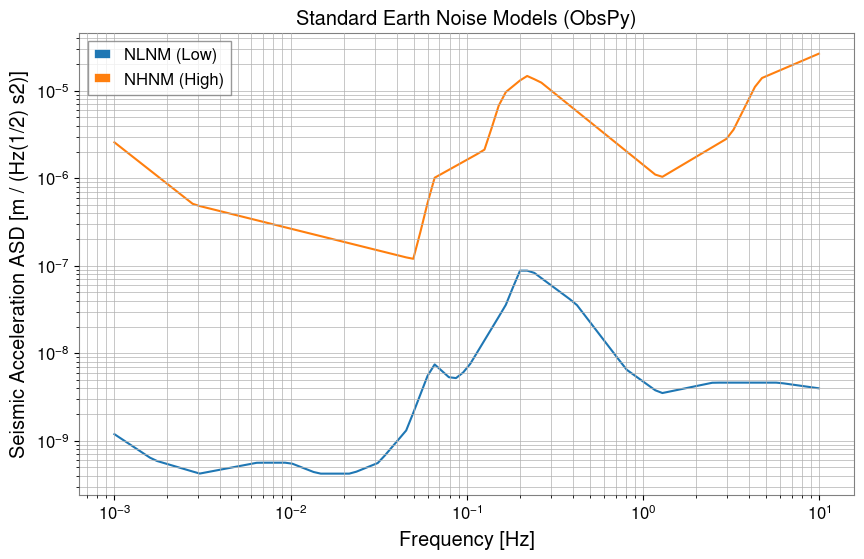

In [3]:
try:
    # 周波数軸を指定して NLNM (Low Noise Model) を取得
    freqs = np.logspace(-3, 1, 100)  # 1mHz - 10Hz
    nlnm = from_obspy('NLNM', frequencies=freqs)
    nhnm = from_obspy('NHNM', frequencies=freqs)

    # プロット (Base unit: m/s^2/sqrt(Hz))
    fig, ax = plt.subplots()
    ax.loglog(nlnm.frequencies, nlnm, label='NLNM (Low)')
    ax.loglog(nhnm.frequencies, nhnm, label='NHNM (High)')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(f'Seismic Acceleration ASD [{nlnm.unit}]')
    ax.grid(True, which='both')
    ax.legend()
    ax.set_title('Standard Earth Noise Models (ObsPy)')
    plt.show()
except ImportError:
    print("obspy がインストールされていないため、このセクションはスキップします。")

### 単位変換と積分

`unit` 引数を指定すると、加速度から速度や変位への積分、および単位変換を自動的に行います。

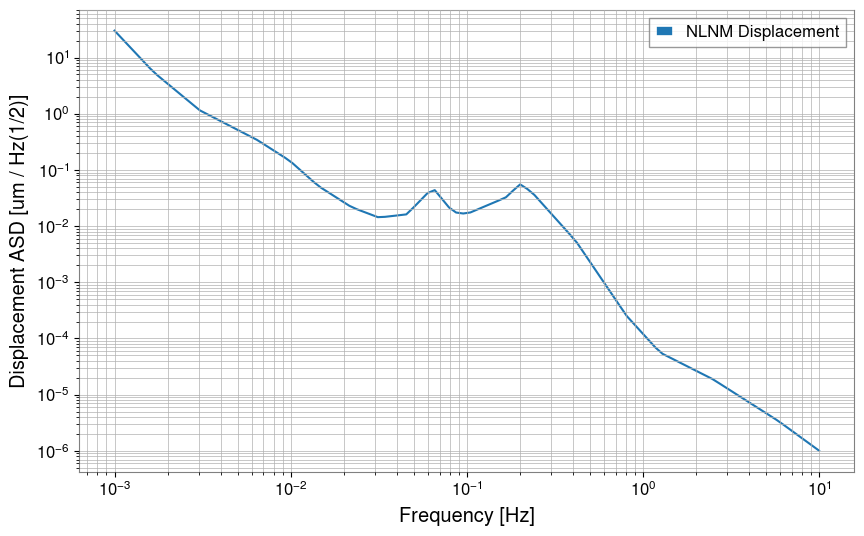

In [4]:
try:
    # 地震の「変位」ASD を nm/sqrt(Hz) で取得
    nlnm_disp = from_obspy('NLNM', frequencies=freqs, unit='um / Hz^(1/2)')
    
    # プロット
    fig, ax = plt.subplots()
    ax.loglog(nlnm_disp.frequencies, nlnm_disp, label='NLNM Displacement')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(f'Displacement ASD [{nlnm_disp.unit}]')
    ax.grid(True, which='both')
    ax.legend()
    plt.show()
except ImportError:
    pass

## 3. インフラサウンド (気圧ノイズ)

IDC (International Data Centre) のインフラサウンド標準ノイズモデルも同様に取得できます。

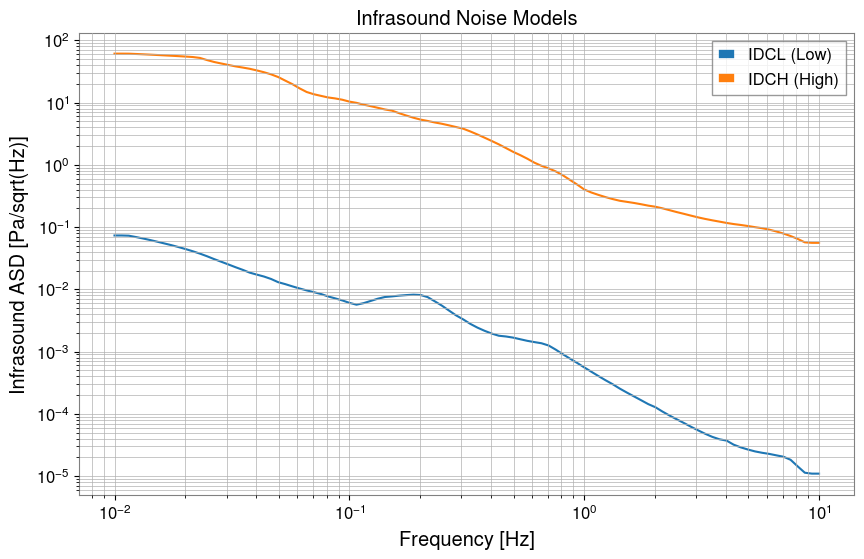

In [5]:
try:
    f_infra = np.logspace(-2, 1, 100)
    idcl = from_obspy('IDCL', frequencies=f_infra)
    idch = from_obspy('IDCH', frequencies=f_infra)
    
    # hPa への単位変換も可能
    idcl_hpa = from_obspy('IDCL', frequencies=f_infra, unit='hPa / Hz^(1/2)')
    
    fig, ax = plt.subplots()
    ax.loglog(idcl.frequencies, idcl, label='IDCL (Low)')
    ax.loglog(idch.frequencies, idch, label='IDCH (High)')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Infrasound ASD [Pa/sqrt(Hz)]')
    ax.grid(True, which='both')
    ax.legend()
    ax.set_title('Infrasound Noise Models')
    plt.show()
except ImportError:
    pass